In [1]:
from typing import List

import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as cs
import hvplot
import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor

In [100]:
sklearn.set_config(transform_output="polars")

# Utility Functions

In [96]:
def create_features(dataframe:pl.DataFrame) -> pl.DataFrame:
    """
    Create time series features based on time series index.
    """
    return (
       dataframe
       .sort("Datetime")
        .with_columns(
            pl.col("Datetime").dt.hour().alias("hour"),
           pl.col("Datetime").dt.weekday().alias("dayofweek"),
           pl.col("Datetime").dt.quarter().alias("quarter"),
           pl.col("Datetime").dt.month().alias("month"),
           pl.col("Datetime").dt.year().alias("year"),
           pl.col("Datetime").dt.ordinal_day().alias("dayofyear"),
           pl.col("Datetime").dt.day().alias("dayofmonth"),
           pl.col("Datetime").dt.week().alias("weekofyear"),
        )
)


def filter_components(df: pl.DataFrame, features: List[str], limit_components: int,
                      mag_threshold: float) -> pl.DataFrame:
    """Filter components based on threshold"""
    columns: List[str] = components_dataframe.columns[:limit_components]
    return (
        df
        .select(*columns,
                pl.Series(features).alias("feature"))
        .filter((pl.any_horizontal(cs.numeric().abs()).gt(mag_threshold)))
    )


### Dataset

In [4]:
dataset: pl.DataFrame = pl.read_csv(
    "~/Developer/xgboostProject/data/01_raw/PJME_hourly.csv"
)

In [5]:
print(dataset)

shape: (145_366, 2)
┌─────────────────────┬─────────┐
│ Datetime            ┆ PJME_MW │
│ ---                 ┆ ---     │
│ str                 ┆ f64     │
╞═════════════════════╪═════════╡
│ 2002-12-31 01:00:00 ┆ 26498.0 │
│ 2002-12-31 02:00:00 ┆ 25147.0 │
│ 2002-12-31 03:00:00 ┆ 24574.0 │
│ 2002-12-31 04:00:00 ┆ 24393.0 │
│ 2002-12-31 05:00:00 ┆ 24860.0 │
│ …                   ┆ …       │
│ 2018-01-01 20:00:00 ┆ 44284.0 │
│ 2018-01-01 21:00:00 ┆ 43751.0 │
│ 2018-01-01 22:00:00 ┆ 42402.0 │
│ 2018-01-01 23:00:00 ┆ 40164.0 │
│ 2018-01-02 00:00:00 ┆ 38608.0 │
└─────────────────────┴─────────┘


In [6]:
df: pl.DataFrame = dataset.select(
    pl.col("Datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"),
    pl.col("PJME_MW").cast(pl.Float32),
)

:Curve   [Datetime]   (PJME_MW)
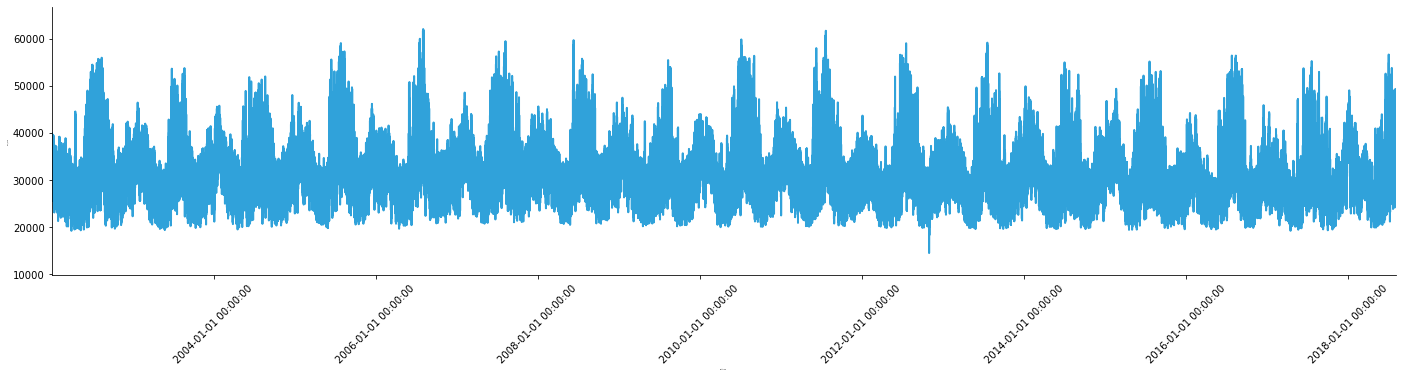

In [104]:
df.plot(x="Datetime", y="PJME_MW", width=1100, height=400, rot=45, fontsize=1.5, xlabel="Datetime", ylabel="PJME_MW")

# TRAIN / TEST SPLIT

In [8]:
train: pl.DataFrame = df.filter(pl.col("Datetime") < pl.datetime(2015, 1, 1))
test: pl.DataFrame = df.filter(pl.col("Datetime") >= pl.datetime(2015, 1, 1))

In [9]:
print(train)

shape: (113_926, 2)
┌─────────────────────┬─────────┐
│ Datetime            ┆ PJME_MW │
│ ---                 ┆ ---     │
│ datetime[μs]        ┆ f32     │
╞═════════════════════╪═════════╡
│ 2002-12-31 01:00:00 ┆ 26498.0 │
│ 2002-12-31 02:00:00 ┆ 25147.0 │
│ 2002-12-31 03:00:00 ┆ 24574.0 │
│ 2002-12-31 04:00:00 ┆ 24393.0 │
│ 2002-12-31 05:00:00 ┆ 24860.0 │
│ …                   ┆ …       │
│ 2014-01-01 20:00:00 ┆ 36193.0 │
│ 2014-01-01 21:00:00 ┆ 35601.0 │
│ 2014-01-01 22:00:00 ┆ 34242.0 │
│ 2014-01-01 23:00:00 ┆ 32215.0 │
│ 2014-01-02 00:00:00 ┆ 30159.0 │
└─────────────────────┴─────────┘


In [106]:
(
    train.with_columns(source=pl.lit("train"))
    .vstack(test.with_columns(source=pl.lit("test")))
    .pivot(
        columns=["source"],
        index="Datetime",
        values="PJME_MW",
        aggregate_function="mean",
    )
    .plot(
        width=1100,
        height=400,
        x="Datetime",
        rot=45,
        fontscale=1.5
    )
)

ShapeError: unable to append to a DataFrame of width 11 with a DataFrame of width 12

In [11]:
(
    df.filter(
        pl.col("Datetime").is_between(pl.datetime(2010, 1, 1), pl.datetime(2010, 1, 8))
    )
    .plot(x="Datetime", y="PJME_MW", width=1100, height=400, title="Week of Data", fontscale=1.5, rot=45)
)

:Curve   [Datetime]   (PJME_MW)

# FEATURE ENGINEERING

In [12]:
dataframe : pl.DataFrame = create_features(df)

In [13]:
print(dataframe)

shape: (145_366, 10)
┌──────────────┬─────────┬──────┬───────────┬───┬──────┬───────────┬────────────┬────────────┐
│ Datetime     ┆ PJME_MW ┆ hour ┆ dayofweek ┆ … ┆ year ┆ dayofyear ┆ dayofmonth ┆ weekofyear │
│ ---          ┆ ---     ┆ ---  ┆ ---       ┆   ┆ ---  ┆ ---       ┆ ---        ┆ ---        │
│ datetime[μs] ┆ f32     ┆ i8   ┆ i8        ┆   ┆ i32  ┆ i16       ┆ i8         ┆ i8         │
╞══════════════╪═════════╪══════╪═══════════╪═══╪══════╪═══════════╪════════════╪════════════╡
│ 2002-01-01   ┆ 30393.0 ┆ 1    ┆ 2         ┆ … ┆ 2002 ┆ 1         ┆ 1          ┆ 1          │
│ 01:00:00     ┆         ┆      ┆           ┆   ┆      ┆           ┆            ┆            │
│ 2002-01-01   ┆ 29265.0 ┆ 2    ┆ 2         ┆ … ┆ 2002 ┆ 1         ┆ 1          ┆ 1          │
│ 02:00:00     ┆         ┆      ┆           ┆   ┆      ┆           ┆            ┆            │
│ 2002-01-01   ┆ 28357.0 ┆ 3    ┆ 2         ┆ … ┆ 2002 ┆ 1         ┆ 1          ┆ 1          │
│ 03:00:00     ┆         ┆   

# Visualize our features / target relationship

In [14]:
(
    dataframe
    .plot.box(y="PJME_MW", by="hour", width=1000, height=600, fontscale=1.6, colorbar=True)
)

:BoxWhisker   [hour]   (PJME_MW)

In [15]:
(
    dataframe
    .plot.box(y="PJME_MW", by="month", width=1000, height=400, fontscale=1.6, colorbar=True)      
)

:BoxWhisker   [month]   (PJME_MW)

# Create Model

In [16]:
train: pl.DataFrame = create_features(train)
test: pl.DataFrame = create_features(test)

FEATURES: List[str] = ["dayofyear", "hour", "dayofweek", "quarter", "month", "year"]
TARGET: str = "PJME_MW"

X_train: pl.DataFrame = train.select(FEATURES)
y_train: pl.DataFrame = train.select(TARGET)

X_test: pl.DataFrame = test.select(FEATURES)
y_test: pl.DataFrame = test.select(TARGET)


In [17]:
print(test)

shape: (31_440, 10)
┌──────────────┬─────────┬──────┬───────────┬───┬──────┬───────────┬────────────┬────────────┐
│ Datetime     ┆ PJME_MW ┆ hour ┆ dayofweek ┆ … ┆ year ┆ dayofyear ┆ dayofmonth ┆ weekofyear │
│ ---          ┆ ---     ┆ ---  ┆ ---       ┆   ┆ ---  ┆ ---       ┆ ---        ┆ ---        │
│ datetime[μs] ┆ f32     ┆ i8   ┆ i8        ┆   ┆ i32  ┆ i16       ┆ i8         ┆ i8         │
╞══════════════╪═════════╪══════╪═══════════╪═══╪══════╪═══════════╪════════════╪════════════╡
│ 2015-01-01   ┆ 32802.0 ┆ 0    ┆ 4         ┆ … ┆ 2015 ┆ 1         ┆ 1          ┆ 1          │
│ 00:00:00     ┆         ┆      ┆           ┆   ┆      ┆           ┆            ┆            │
│ 2015-01-01   ┆ 31647.0 ┆ 1    ┆ 4         ┆ … ┆ 2015 ┆ 1         ┆ 1          ┆ 1          │
│ 01:00:00     ┆         ┆      ┆           ┆   ┆      ┆           ┆            ┆            │
│ 2015-01-01   ┆ 30755.0 ┆ 2    ┆ 4         ┆ … ┆ 2015 ┆ 1         ┆ 1          ┆ 1          │
│ 02:00:00     ┆         ┆    

In [18]:
print(X_test)

shape: (31_440, 6)
┌───────────┬──────┬───────────┬─────────┬───────┬──────┐
│ dayofyear ┆ hour ┆ dayofweek ┆ quarter ┆ month ┆ year │
│ ---       ┆ ---  ┆ ---       ┆ ---     ┆ ---   ┆ ---  │
│ i16       ┆ i8   ┆ i8        ┆ i8      ┆ i8    ┆ i32  │
╞═══════════╪══════╪═══════════╪═════════╪═══════╪══════╡
│ 1         ┆ 0    ┆ 4         ┆ 1       ┆ 1     ┆ 2015 │
│ 1         ┆ 1    ┆ 4         ┆ 1       ┆ 1     ┆ 2015 │
│ 1         ┆ 2    ┆ 4         ┆ 1       ┆ 1     ┆ 2015 │
│ 1         ┆ 3    ┆ 4         ┆ 1       ┆ 1     ┆ 2015 │
│ 1         ┆ 4    ┆ 4         ┆ 1       ┆ 1     ┆ 2015 │
│ …         ┆ …    ┆ …         ┆ …       ┆ …     ┆ …    │
│ 214       ┆ 20   ┆ 4         ┆ 3       ┆ 8     ┆ 2018 │
│ 214       ┆ 21   ┆ 4         ┆ 3       ┆ 8     ┆ 2018 │
│ 214       ┆ 22   ┆ 4         ┆ 3       ┆ 8     ┆ 2018 │
│ 214       ┆ 23   ┆ 4         ┆ 3       ┆ 8     ┆ 2018 │
│ 215       ┆ 0    ┆ 5         ┆ 3       ┆ 8     ┆ 2018 │
└───────────┴──────┴───────────┴─────────┴───────┴───

In [19]:
reg: XGBRegressor =XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000,
             early_stopping_rounds=50, objective="reg:squarederror",
             max_depth=3, learning_rate=0.01)

In [20]:
reg

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [21]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907
[100]	validation_0-rmse:12581.21569	validation_1-rmse:11743.75114
[200]	validation_0-rmse:5835.12466	validation_1-rmse:5365.67709
[300]	validation_0-rmse:3915.75557	validation_1-rmse:4020.67023
[400]	validation_0-rmse:3443.16468	validation_1-rmse:3853.40423
[500]	validation_0-rmse:3285.33804	validation_1-rmse:3805.30176
[600]	validation_0-rmse:3201.92936	validation_1-rmse:3772.44933
[700]	validation_0-rmse:3148.14225	validation_1-rmse:3750.91108
[800]	validation_0-rmse:3109.24248	validation_1-rmse:3733.89713
[900]	validation_0-rmse:3079.40079	validation_1-rmse:3725.61224
[999]	validation_0-rmse:3052.73503	validation_1-rmse:3722.92257


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Feature Importance

In [22]:
fi: pl.DataFrame = pl.DataFrame(
    {
        "feature": FEATURES,
        "importance": reg.feature_importances_
    }
)

In [23]:
(
    fi
    .plot.barh(x="feature", y="importance", width=1100, height=400,
               title="Feature Importance", fontscale=1.5, rot=45)
)

:Bars   [feature]   (importance)

### PCA

In [24]:
pca: PCA = PCA()

In [25]:
pca

PCA()

In [26]:
X: pl.DataFrame = (
    dataframe
    .select(FEATURES)
)

In [27]:
print(X)

shape: (145_366, 6)
┌───────────┬──────┬───────────┬─────────┬───────┬──────┐
│ dayofyear ┆ hour ┆ dayofweek ┆ quarter ┆ month ┆ year │
│ ---       ┆ ---  ┆ ---       ┆ ---     ┆ ---   ┆ ---  │
│ i16       ┆ i8   ┆ i8        ┆ i8      ┆ i8    ┆ i32  │
╞═══════════╪══════╪═══════════╪═════════╪═══════╪══════╡
│ 1         ┆ 1    ┆ 2         ┆ 1       ┆ 1     ┆ 2002 │
│ 1         ┆ 2    ┆ 2         ┆ 1       ┆ 1     ┆ 2002 │
│ 1         ┆ 3    ┆ 2         ┆ 1       ┆ 1     ┆ 2002 │
│ 1         ┆ 4    ┆ 2         ┆ 1       ┆ 1     ┆ 2002 │
│ 1         ┆ 5    ┆ 2         ┆ 1       ┆ 1     ┆ 2002 │
│ …         ┆ …    ┆ …         ┆ …       ┆ …     ┆ …    │
│ 214       ┆ 20   ┆ 4         ┆ 3       ┆ 8     ┆ 2018 │
│ 214       ┆ 21   ┆ 4         ┆ 3       ┆ 8     ┆ 2018 │
│ 214       ┆ 22   ┆ 4         ┆ 3       ┆ 8     ┆ 2018 │
│ 214       ┆ 23   ┆ 4         ┆ 3       ┆ 8     ┆ 2018 │
│ 215       ┆ 0    ┆ 5         ┆ 3       ┆ 8     ┆ 2018 │
└───────────┴──────┴───────────┴─────────┴───────┴──

In [28]:
pca.fit(X)

PCA()

In [29]:
components_dataframe: pl.DataFrame = (
    pl.DataFrame(pca.components_)
    .rename(mapping={f"column_{i}": f"PC_{i+1}" for i in range(len(X.columns))})
)

In [91]:
print(components_dataframe)


shape: (6, 6)
┌───────────┬───────────┬───────────┬────────────┬───────────┬───────────┐
│ PC_1      ┆ PC_2      ┆ PC_3      ┆ PC_4       ┆ PC_5      ┆ PC_6      │
│ ---       ┆ ---       ┆ ---       ┆ ---        ┆ ---       ┆ ---       │
│ f64       ┆ f64       ┆ f64       ┆ f64        ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪════════════╪═══════════╪═══════════╡
│ 0.999415  ┆ -0.000004 ┆ -0.000003 ┆ 0.010255   ┆ 0.032575  ┆ -0.001976 │
│ -0.000003 ┆ -1.0      ┆ -0.0001   ┆ -1.4259e-7 ┆ -0.000004 ┆ 0.000177  │
│ 0.00198   ┆ 0.000177  ┆ -0.000021 ┆ -0.000004  ┆ -0.000108 ┆ 0.999998  │
│ -0.000001 ┆ -0.0001   ┆ 1.0       ┆ 0.000088   ┆ 0.000091  ┆ 0.000021  │
│ 0.031001  ┆ 0.000003  ┆ 0.000127  ┆ -0.672511  ┆ -0.739438 ┆ -0.000144 │
│ -0.014324 ┆ -0.000003 ┆ 0.000004  ┆ -0.740016  ┆ 0.672437  ┆ 0.000099  │
└───────────┴───────────┴───────────┴────────────┴───────────┴───────────┘


In [97]:
components_df: pl.DataFrame = filter_components(components_dataframe, FEATURES,3 , 0.1)

In [98]:
print(components_df)

shape: (6, 4)
┌───────────┬───────────┬───────────┬───────────┐
│ PC_1      ┆ PC_2      ┆ PC_3      ┆ feature   │
│ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64       ┆ f64       ┆ f64       ┆ str       │
╞═══════════╪═══════════╪═══════════╪═══════════╡
│ 0.999415  ┆ -0.000004 ┆ -0.000003 ┆ dayofyear │
│ -0.000003 ┆ -1.0      ┆ -0.0001   ┆ hour      │
│ 0.00198   ┆ 0.000177  ┆ -0.000021 ┆ dayofweek │
│ -0.000001 ┆ -0.0001   ┆ 1.0       ┆ quarter   │
│ 0.031001  ┆ 0.000003  ┆ 0.000127  ┆ month     │
│ -0.014324 ┆ -0.000003 ┆ 0.000004  ┆ year      │
└───────────┴───────────┴───────────┴───────────┘


In [99]:
(
    components_df
    .select(cs.numeric())
    .transpose()
    .rename(mapping={ f"column_{i}": col for i, col in enumerate(components_df.select("feature").to_series()) 
    })
    .plot.bar(width=1100, height=400, title="PCA Components", fontscale=1.5, rot=45)
)

:Bars   [index,Variable]   (value)

# Forecast on Test

In [33]:
test: pl.DataFrame = (
    test
    .with_columns(prediction=pl.Series(reg.predict(X_test)))
)

In [34]:
print(test)

shape: (31_440, 11)
┌─────────────┬─────────┬──────┬───────────┬───┬───────────┬────────────┬────────────┬─────────────┐
│ Datetime    ┆ PJME_MW ┆ hour ┆ dayofweek ┆ … ┆ dayofyear ┆ dayofmonth ┆ weekofyear ┆ prediction  │
│ ---         ┆ ---     ┆ ---  ┆ ---       ┆   ┆ ---       ┆ ---        ┆ ---        ┆ ---         │
│ datetime[μs ┆ f32     ┆ i8   ┆ i8        ┆   ┆ i16       ┆ i8         ┆ i8         ┆ f32         │
│ ]           ┆         ┆      ┆           ┆   ┆           ┆            ┆            ┆             │
╞═════════════╪═════════╪══════╪═══════════╪═══╪═══════════╪════════════╪════════════╪═════════════╡
│ 2015-01-01  ┆ 32802.0 ┆ 0    ┆ 4         ┆ … ┆ 1         ┆ 1          ┆ 1          ┆ 30527.79492 │
│ 00:00:00    ┆         ┆      ┆           ┆   ┆           ┆            ┆            ┆ 2           │
│ 2015-01-01  ┆ 31647.0 ┆ 1    ┆ 4         ┆ … ┆ 1         ┆ 1          ┆ 1          ┆ 29436.33789 │
│ 01:00:00    ┆         ┆      ┆           ┆   ┆           ┆           

In [35]:
predicted_dataframe: pl.DataFrame = (
    dataframe
    .join(test.select("Datetime", "prediction"), on="Datetime", how="left")
)

In [36]:
print(predicted_dataframe)

shape: (145_372, 11)
┌─────────────┬─────────┬──────┬───────────┬───┬───────────┬────────────┬────────────┬─────────────┐
│ Datetime    ┆ PJME_MW ┆ hour ┆ dayofweek ┆ … ┆ dayofyear ┆ dayofmonth ┆ weekofyear ┆ prediction  │
│ ---         ┆ ---     ┆ ---  ┆ ---       ┆   ┆ ---       ┆ ---        ┆ ---        ┆ ---         │
│ datetime[μs ┆ f32     ┆ i8   ┆ i8        ┆   ┆ i16       ┆ i8         ┆ i8         ┆ f32         │
│ ]           ┆         ┆      ┆           ┆   ┆           ┆            ┆            ┆             │
╞═════════════╪═════════╪══════╪═══════════╪═══╪═══════════╪════════════╪════════════╪═════════════╡
│ 2002-01-01  ┆ 30393.0 ┆ 1    ┆ 2         ┆ … ┆ 1         ┆ 1          ┆ 1          ┆ null        │
│ 01:00:00    ┆         ┆      ┆           ┆   ┆           ┆            ┆            ┆             │
│ 2002-01-01  ┆ 29265.0 ┆ 2    ┆ 2         ┆ … ┆ 1         ┆ 1          ┆ 1          ┆ null        │
│ 02:00:00    ┆         ┆      ┆           ┆   ┆           ┆          

In [37]:
(
    predicted_dataframe
    .plot(
        width=1100,
        height=400,
        x="Datetime",
        y=["PJME_MW", "prediction"],
        rot=45,
        fontscale=1.2,
        title="Raw Data and Prediction"
    )
)

:NdOverlay   [Variable]
   :Curve   [Datetime]   (value)

In [38]:
(
    predicted_dataframe
    .filter(
        pl.col("Datetime").is_between(pl.datetime(2018, 4, 1), pl.datetime(2018, 4, 8)))
    .plot(
        width=1100,
        height=400,
        x="Datetime",
        y=["PJME_MW", "prediction"],
        line_dash=["solid", "dotdash"],
        rot=45,
        fontscale=1.2,
        title="Week of data prediction"
    )
)

:NdOverlay   [Variable]
   :Curve   [Datetime]   (value)

Score (RMSE)

In [39]:
score = root_mean_squared_error(test.select("PJME_MW"), test.select("prediction"))

In [40]:
print(f"RMSE Score on test set: {score :,.1f}")

RMSE Score on test set: 3,721.7


## Calculated error

In [41]:
(
    test
    .select(pl.col("Datetime").dt.date().alias("date"), 
            pl.col("PJME_MW"), 
            pl.col("prediction"))
    .with_columns((pl.col("PJME_MW").abs() - pl.col("prediction").abs()).alias("error"))
    .group_by("date")
    .agg(pl.col("error").mean().alias("error"))
    .sort("error", descending=True)
    .limit(10)
)

shape: (10, 2)
┌────────────┬──────────────┐
│ date       ┆ error        │
│ ---        ┆ ---          │
│ date       ┆ f32          │
╞════════════╪══════════════╡
│ 2016-08-13 ┆ 12839.59668  │
│ 2016-08-14 ┆ 12780.209961 │
│ 2016-09-10 ┆ 11356.302734 │
│ 2015-02-20 ┆ 10965.982422 │
│ 2016-09-09 ┆ 10864.955078 │
│ 2018-01-06 ┆ 10506.845703 │
│ 2016-08-12 ┆ 10124.051758 │
│ 2015-02-21 ┆ 9881.803711  │
│ 2015-02-16 ┆ 9781.552734  │
│ 2018-01-07 ┆ 9739.144531  │
└────────────┴──────────────┘